#IST664 - NLP Lab Week 7 - Embeddings#

Embeddings are vector space representations of linguistic constructs. Starting with word2vec, researchers have used deep learning models to generate embedding vectors that represent the semantics of words and larger elements. In this lab, we will practice using word and sentence embeddings in a variety of ways. In the first part of the lab, we will use a "large" spaCy model that contains context-free word embeddings. Context-free means that the vector is static, regardless of what word sense we are using. Note that the first code cell below may take a couple minutes to load, so you may want to set it running before you take a break. 

In the second part of the lab we will use a sentence embedding model obtained from huggingface.co and perform a parallel set of analyses using those sentence summary vectors. With words it is possible to develop a fairly comprehensive dictionary of vector representations with 100,000 entries or perhaps more. With sentences, however, there are just too many possibilities to be able to represent each one with a stored vector. The alternative strategy used by deep learning summarizer models is to process any given input sentence through a complete, pre-trained model. This processing step is sometimes referred to as "inference," as it is conceptually similar to using a trained predictive model on novel data. After processing a sentence, we can extract a vector representation from the internal state of the model.

In [61]:
# Load a large spaCy model to get the word embeddings included with spaCy.
# Note that this may take two or three minutes.
import spacy
import spacy.cli # Use the command line interface
spacy.cli.download("en_core_web_lg") # This imports the large model onto your virtual machine
import en_core_web_lg # Now that it is downloaded, we can import it
nlp_lg = en_core_web_lg.load() # Create an instance for further use
type(nlp_lg)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


spacy.lang.en.English

In [62]:
# Let's begin by processing one word and making sure it has an embedding vector
my_word = "natural"
natural = nlp_lg(my_word)
type(natural), natural[0].has_vector

(spacy.tokens.doc.Doc, True)

In [63]:
# Remember that a "doc" is a list-like object where each element is a token.
# So we can use slicing to get access to the one and only token in this doc.
len(natural[0].vector) # Shows the dimensionality of spaCy vector space representations

300

(array([ 5., 21., 40., 73., 74., 46., 30.,  7.,  3.,  1.]),
 array([-7.4216    , -5.72088   , -4.0201597 , -2.31944   , -0.61871994,
         1.082     ,  2.78272   ,  4.48344   ,  6.1841598 ,  7.88488   ,
         9.5856    ], dtype=float32),
 <BarContainer object of 10 artists>)

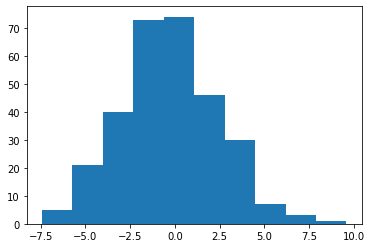

In [4]:
# Get a flavor for the distribution of the elements of the vector. The mean of 
# the vector elements is typically near zero. The SD of this distribution is
# about 2.5.
import matplotlib.pyplot as plt
plt.hist(natural[0].vector)

In [64]:
# The vectors are kept in spaCy's vocabulary store which can also be accessed 
# directly as follows: 
direct = nlp_lg.vocab[my_word].vector

len(direct)

300

In [65]:
# Note the vector math inside of this expression. The sum() function then
# adds together all of the differences.
sum(direct - natural[0].vector) # Quick test of identity: 
# A sum of zero means that the two vectors are likely to be identical

0.0

In [66]:
# Another way of testing the equality of two vectors is to use the all() method
(direct == natural[0].vector).all()

True

In [8]:
#
# Exercise 7.1: Make up a word that does not exist in English and try to 
# access spaCy's vocabulary store with that word. What happens?
#
my_non_word = "amuliko"
direct2 = nlp_lg.vocab[my_non_word].vector

direct2

#This creates a zero matrix - indicating that the word doesnt exist in vocabulory in spaCy

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [67]:
# SpaCy has a method for finding similar words. This is a standard kind of
# function in a word embedding package, available in word2vec and other
# embedding code libraries. The underlying code may use hashing tricks to
# speed up the search through the vocabulary.
import numpy as np

similar = nlp_lg.vocab.vectors.most_similar(np.asarray([direct]), n=10)
word_list = [nlp_lg.vocab.strings[w] for w in similar[0][0]]
print(word_list)

['natural', 'Allnatural', 'allnatural', 'Unnatural', 'naturals', 'naturaleza', 'naturall', 'naturalness', 'unnatural', 'naturales']


In [68]:
type(similar), len(similar) # What is the similar object?

(tuple, 3)

*Important note:* The most_similar() method called above returns a tuple with three elements. Each of the elements is a list and each of the lists contains ten items. The next three code cells explore the contents of these lists.

In [69]:
# similar[0] contains the ID "key" numbers of the 10 similar words from spaCy's vocabulary store.
# Keep in mind that it is possible that two or more words/keys may point to the same vector.
type(similar[0]), similar[0] # There should be ten ids/keys

(numpy.ndarray,
 array([[ 3743574233330547430,  4345611927055728999,  6284918608836433127,
          5842587109985371347,  6767650875811059939,  2255247291837283518,
          3303657296512507660, 15938995882200426271,  8711931566637541906,
         10593631900353219748]], dtype=uint64))

In [70]:
# similar[1] contains the "best rows" from the vector table providing a faster
# way to lookup the corresponding vectors if necessary.
type(similar[1]), similar[1] # There should be ten row indices

(numpy.ndarray,
 array([[   918, 483900, 168805, 102824,  97833, 316180, 509311, 104487,
          25199, 304228]], dtype=int32))

In [71]:
# similar[2] contains the cosine similarity scores between the reference word
# and the top 10 words that spaCy found. Note how the first entry
# (the word "natural") has similarity equal to one.
type(similar[2]), similar[2] # There should be ten cosine similarity scores

(numpy.ndarray,
 array([[1.    , 0.9332, 0.9196, 0.8829, 0.8738, 0.8519, 0.8495, 0.8249,
         0.8161, 0.8155]], dtype=float32))

In [72]:
# Possibly helpful for the next exercise, numpy's argmax function returns
# the POSITION within a list of the maximum value in the list. Here's a demo:
np.argmax([4,3,3,3,3])

0

In [80]:
# 
# Exercise 7.2: Write a loop or other code that use the similarity scores
# from similar[2], first to eliminate instances of the same word (i.e., where similarity
# equals one) from the list and then, second, to print the word with the maximum similarity 
# score among the remaining values.

# This might help: It extracts each piece of the similarity tuple as a non-nested list
key, row, sim = similar[0].tolist()[0], similar[1].tolist()[0], similar[2].tolist()[0]
# So "sim" now contains a list of the similarity scores
for i in range(len(sim)):
   if sim[i]==1:
     sim[i]=0


# Hint: Start by looping through "sim" to modify each value of 1 into a value of 0.
# This will "blank out" the word(s) that are identical to the original probe word.
max_index=np.argmax(sim)
print(word_list[max_index])

#Modified the sim[i] for any value as 1 to 0. Then printed the word with highest similarity
#The word with highest similarity is "Allnatural"

Allnatural


Now that we know how to access spaCy's word vector data, let's try a couple of semantic tests to see how the vectors perform.

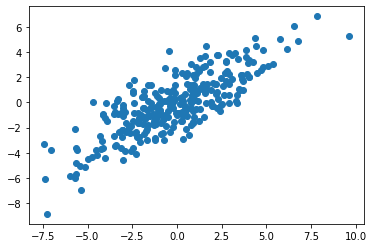

In [22]:
# Now let's examine what happens with vectors when we make a syntactic 
# transformation from adjective to adverb.
import matplotlib.pyplot as plt

# Remember this code from above that gets the vector for "natural":
# direct = nlp_lg.vocab[my_word].vector

naturally = nlp_lg.vocab["naturally"].vector # Look up the vector for the adverbial form

plt.scatter(direct, naturally)

# Discuss with you partner:

What do the X and Y axes represent in that scatterplot? Why does that scatterplot have the shape that it does? Some statisticians would say that the plot has a "cigar shape" and that this shape provides an important clue about the correlation between the two variables. Do you think the two variables are correlated? What does that imply about the word "natural" and the word "naturally?"

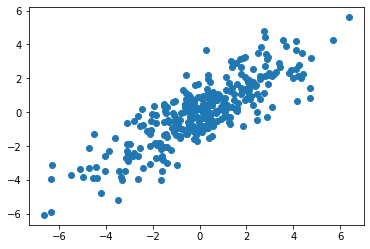

In [25]:
#
# Exercise 7.3: Choose a different adjective, such as "powerful", as well as
# its adverbial form. Obtain the two word vectors as shown earlier
# and plot the two vectors as a scattergram. Are there any parallels to
# the chart above? 
#
#powerful - is adjective
#powerfully is adverb

direct = nlp_lg.vocab["powerful"].vector
naturally = nlp_lg.vocab["powerfully"].vector # Look up the vector for the adverbial form

plt.scatter(direct, naturally)

#X axis represents the embedding of similar words to powerful
#Y axis represents the embedding of similar words to powerfully
#The shape shows that there is a positive and strong correlation between the words
#Yes these two words are correlated as we can see their similar words near to each other
#This implies that "natural" and "naturally" are very similar in meaning 
#and lie close to each other in embedding space


Just as NLPIA says, we don't really know what each element of a vector actually signifies semantically. But that does not stop use from working with these vectors to explore semantics. In this next exercise, we use Kmeans clustering, a simple geometric technique for allocating points to clusters. Each cluster ends up being represented by a center point (a centroid), which in this case will be in d=300 space. So if we had a cluster that contained the word vectors for "milk," "cheese," and "yogurt," the centroid would look like a word vector but would not represent a particular word, but rather a dairy-product middle position in between "milk," "cheese," and "yogurt." We can treat a centroid as if it were a word vector by finding words that are similar to it.

In [37]:
# Next, let's get the word vectors for a variety of adjectives and cluster them.
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2) # Let's get a two cluster solution

adjectives = nlp_lg("big gigantic massive long tall spicy bitter sour tart zesty")

vect_list = [tok.vector for tok in adjectives]

km.fit(vect_list)

clusters = km.cluster_centers_
len(clusters[0]) # cluster[0] is the vector representing the first cluster center

300

(array([ 5., 15., 27., 64., 75., 66., 34., 12.,  0.,  2.]),
 array([-5.83743997, -4.52281797, -3.20819598, -1.89357399, -0.578952  ,
         0.73566999,  2.05029199,  3.36491398,  4.67953597,  5.99415796,
         7.30877995]),
 <BarContainer object of 10 artists>)

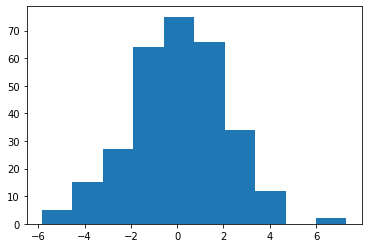

In [38]:
plt.hist(clusters[0]) # This suggests that the cluster center is a typical-looking
# embedding vector even though it is not a real word but rather a position in 
# d=300 space determined by km.fit().

Each of the two cluster centers represents a point in d=300 space that is in the geometric "middle" of all of the word vectors that Kmeans assigned to each cluster. But the cluster center is not itself a vector for a particular word. So how can we find out what each cluster center is all about? You guessed it: We do a similarity search, with spaCy's help, to find out which words are closest to each cluster center.

In [81]:
#
# Exercise 7.4: Find the nearest 10 words to each of the two cluster centers
# Here's the relevant code from up above for obtaining a list of similar words. 
# What is the one argument you need to change?
#
similar = nlp_lg.vocab.vectors.most_similar(np.asarray([clusters[0]]), n=10)
[nlp_lg.vocab.strings[w] for w in similar[0][0]]



['worldbuilding',
 'superstructures',
 'freestanding',
 'groundings',
 'overbuilding',
 'deckbuilding',
 'hight',
 'wilding',
 'interchangable',
 'upbuilding']

In [47]:
# Here are two sentences from Wikipedia:
two_sentences = "Shanghai Tower is the world's third-tallest building by height to architectural top and it shares the record of having the world's highest observation deck within a building or structure. In 2007, Guinness World Records certified that the ghost pepper was the world's hottest chili pepper, 170 times hotter than Tabasco sauce. "
# Scroll right to see the second sentence.

#
# Exercise 7.5: Use spaCy to tokenize "two_sentences: and then remove stop words
# numbers and punctuation from the token stream. Obtain a list of word vectors of the
# remaining words and subject this list to a two cluster Kmeans analysis. Find
# the closest 10 words to each of the resulting cluster centers.
#
#Tokenize
tok =[token for token in nlp_lg(two_sentences)]
tok =[token for token in tok if not token.is_stop] #remove stopwords
tok =[token for token in tok if not token.is_punct] #remove punctuationns
tok =[token for token in tok if not token.like_num] #remove numbers

#Create two cluster kmeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2) 
vect_list = [token.vector for token in tok]
km.fit(vect_list)
clusters = km.cluster_centers_
len(clusters[0]) # cluster[0] is the vector representing the first cluster center
similar = nlp_lg.vocab.vectors.most_similar(np.asarray([clusters[0]]), n=10)
[nlp_lg.vocab.strings[w] for w in similar[0][0]]

['worldbuilding',
 'superstructures',
 'freestanding',
 'groundings',
 'overbuilding',
 'deckbuilding',
 'hight',
 'wilding',
 'interchangable',
 'upbuilding']

There's more to do with word embedding vectors. In particular, there are basic ways to summarize short utterances by computing the mean vector across all the words in the utterance. Some applications perform dimension reduction on a set of word vectors to get a low-dimensional representation of certain linguistic characteristics such as the tense of verbs or the gender of nouns. In class you saw some analogical thinking tasks performed with word vectors. And there are tasks such as synonym searches that word vectors make quite easy.

Despite the usefulness of word vectors, however, the subsequent development of more complex deep learning models opened up the possibility of creating vector representations of phrases, sentences, and longer constructions. To some degree, these models have supplanted the use of word vectors, because they provide greater flexibility and because we are usually interested in analyzing whole utterances rather than isaolated words. The rest of the lab focuses on these sentence embeddings.


***Part 2: Sentence Embeddings***

In this section of the lab, we will load up a pre-trained model that can produce sentence embeddings. With word vectors we could maintain a list of 10k, 100k, or more words in a dictionary. That's not feasible with sentences, though, because language is so expressive: there's effectively an infinite number of possible sentences. As a result, to create a sentence embedding we need a trained model to perform "inference" on an input that we provide - usually in the form of a string containing a complete sentence. Sentence embedding models process the input string through a system of weights to create a long vector that tries to capture the semantics of the whole sentence.
 

In [49]:
# The first thing we will need is the library for loading sentence transformers
# This generates a lot of output, but should run pretty fast.
#!pip install sentence-transformers

In [50]:
# Now load a pre-trained sentence transformer onto this VM. There are hundreds 
# of models to choose from. The model loading process downloads a lot of data 
# to your virtual machine and takes half a minute or so.
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
# Why is it sometimes a good idea to use a multilingual model?

In [51]:
# Let's get the vector for one example sentence:
one_sentence = "Shanghai Tower is the world's third-tallest building by height to architectural top and it shares the record of having the world's highest observation deck within a building or structure."

a = model.encode([one_sentence])
print(a.shape) # Show the shape of the vector: Take note of the dimensionality

(1, 512)


In [53]:
# Here's another sentence that looks cloesely related.
another_sentence = "Shanghai Tower is a 128-story, 632-meter-tall megatall skyscraper in Lujiazui, Pudong, Shanghai that is the world's third-tallest building by height and having the world's highest observation deck at 562 m."

#
# Exercise 7.6: Compute a summary vector for "another_sentence". Show the shape.
#
b = model.encode([another_sentence])
print(b.shape)
#The shape is (1,512)

(1, 512)


In [54]:
#
# Exercise 7.7: Compute the cosine similarity between one_sentence and another_sentence.
# You can use cosine_similarity()from sklearn.metrics.pairwise 
#
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(a,b)

#Cosine similarity between one_sentence and another_sentence is 
#0.818723

array([[0.818723]], dtype=float32)

#Checkpoint! Write the Cosine Similarity on the Board

Looking at the output from Exercise 7.7 just above, round the cosine similarity value to three significant digits and write it on the white board next to your name. 

In [83]:
#
# Exercise 7.8: Copy and paste a sentence from Wikipedia or another source that
# is on a topic other than Shanghai Tower. Create a sentence vector for it.
#
third_sentence = "It is the tallest building in China and the world's third-tallest building by height to architectural top. "
c = model.encode([third_sentence])
print(c.shape)


(1, 512)


In [87]:
#
# Exercise 7.9: Compute cosine similarity between third_sentence and each
# of the other two sentences.
#
print(cosine_similarity(a,c))

#cosine_similarity between first and third sentence : 0.8007

print(cosine_similarity(b,c))

#cosine_similarity between second and third sentence : 0.6742

[[0.8007623]]
[[0.6742576]]


At this point we have created d=512 vector representations of several sentences and used cosine similarity to compare them. Let's load a large dataset of sentences and use that to generate a set of sentence vectors so that we can try out some practical approaches to using the similarities of sentence vectors. 

In [88]:
# ********* Load Data ********* # 
# The following code processes the Twitter Emotion Corpus (TEC)
# Link of paper: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.383.3384&rep=rep1&type=pdf
# Link of web page with dataset: http://saifmohammad.com/WebPages/SentimentEmotionLabeledData.html


# These lines download the zip file to this VM and unzip it onto the disk
!wget http://saifmohammad.com/WebDocs/Jan9-2012-tweets-clean.txt.zip 
!unzip Jan9-2012-tweets-clean.txt.zip

--2023-03-01 16:40:34--  http://saifmohammad.com/WebDocs/Jan9-2012-tweets-clean.txt.zip
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1128895 (1.1M) [application/zip]
Saving to: ‘Jan9-2012-tweets-clean.txt.zip’

Jan9-2012-tweets-cl 100%[===================>]   1.08M  --.-KB/s    in 0.1s    

2023-03-01 16:40:34 (11.3 MB/s) - ‘Jan9-2012-tweets-clean.txt.zip’ saved [1128895/1128895]

Archive:  Jan9-2012-tweets-clean.txt.zip
  inflating: Jan9-2012-tweets-clean.txt  
   creating: __MACOSX/
  inflating: __MACOSX/._Jan9-2012-tweets-clean.txt  


In [89]:
# Now read and process the data file
basefile = "Jan9-2012-tweets-clean.txt" # Should match the name of the unzipped file

# Initialize a list of tweets
texts = []

# Initialize a list of labels
labels = []

with open(basefile, 'r', encoding="utf8") as f:
  for line in f:
    splitted = line.strip().split()
    labels.append(splitted[len(splitted)-1])
    texts.append(' '.join(splitted[1:len(splitted)-2]))
    
print('Loaded %s sentences.' % len(labels))

Loaded 21051 sentences.


In [90]:
#
# Exercise 7.10: The texts of the tweets are in the list "texts". Examine the
# first 10 tweets.
#
texts[:10]

['Thinks that @melbahughes had a great 50th birthday party :)',
 'Como una expresión tan simple, una sola oración, puede llegara dañarte tanto.',
 'the moment when you get another follower and you cheer.',
 'Be the greatest dancer of your life! practice daily positive habits. #fun #freedom #habits',
 'eww.. my moms starting to make her annual rum cake for the whole ramdyal/ally family. fml fml fml the smelll.......',
 "If ur heart hurts all the time for tht person something isn't right where's the",
 "I feel awful, and it's way too freaking early. Now off to leadership highschool...",
 'So chuffed for safc fans! Bet me dar comes in mortz from the match',
 'Making art and viewing art are different at their core!',
 'Soooo dooowwwn!! Move on, get some sleep... Me deserve better. #forgetit #yawning']

In [91]:
# When initially developing some new code it is better to work
# on a smaller chunk to get the bugs out without a huge amount of processing time.
# So let's take 500 of the 21051 tweets. Feel free to process more of the tweets
# once you have finished the rest of the lab.
#
short_list = texts[500:1000]
len(short_list)

500

In [ ]:
# We can run model.encode() on a list of texts. This will take 30-60 seconds
# for a list of 500 tweets.
tweet_vects = model.encode(short_list)

tweet_vects.shape # Make sure you know what these numbers mean

In [ ]:
# Now let's see if we can find all the tweets that pertain to a particular topic. 
# Here's an "anchor sentence" that we can use to generate similarities.
anchor = 149
short_list[anchor]

In [ ]:
# Note how these vector elements appear on a very different scale from 
# spaCy word vectors. Still centered on zero but with a much smaller SD.
# This is a result of using different computational techniques to generate
# the vectors. 

plt.bar(x=range(512), height=tweet_vects[anchor])

In [ ]:
# Compute similarity scores between each sentence and the anchor sentence
sim_list = []

for vect in tweet_vects:
  sim_list.append(cosine_similarity(tweet_vects[anchor].reshape(1,-1), vect.reshape(1,-1)))

len(sim_list), type(sim_list[0])

In [ ]:
# Show a histogram of the similarity values
plt.hist([sim.tolist()[0][0] for sim in sim_list])

In [ ]:
# Now show all of the sentences with a similarity greater than 0.5
#
thresh = 0.5

for i, sim in enumerate(sim_list):
  if sim.tolist()[0][0] > thresh:
    print(short_list[i])

In [ ]:
#
# Exercise 7.11: Write your own anchor sentence that you think might match
# some tweets. Generate a vector representation of that sentence and use
# the vector to create a similarity list across the 500 tweets. Inspect a 
# histogram to get a good cutoff value and display all of the tweets that are
# similar to your anchor sentence.
#


In [ ]:
#
# Exercise 7.12: Interpret a hierarchical cluster (dendrogram) representing
# similarities/differences among a small set of tweets.
#
from sklearn.metrics.pairwise import cosine_distances # To create distance matrix for clustering
from scipy.cluster.hierarchy import dendrogram, linkage # For clustering

start_tweet = 110 # Pick any starting and ending point you like.
end_tweet = 150   # but a dendrogram can only show so much.

smaller_set = tweet_vects[start_tweet:end_tweet] # Subset the vectors
small_labels = [s[0:10] for s in short_list[start_tweet:end_tweet]] # Make some leaf labels

# In this next step, we compute a square cosine distance matrix using the vectors 
dist = cosine_distances(smaller_set, smaller_set)

fig = plt.figure(figsize=(12, 5)) # Make a larger figure area 
link_matrix = linkage(dist, "weighted") # Create the hierarchy
dendrogram(link_matrix, leaf_font_size=8., labels=small_labels) # Plot the result
plt.title("Cluster Dendrogram")
plt.show()

# In the dendrogram, locate the two strings shown in the output two blocks above.

Dendrograms have the advantage that they are easy to explain to non-technical audiences. The larger and smaller distances among elements in the set are easy to spot visually. The disadvantage is that there is no clear assignment of an element to a cluster and there's no clear idea of how many clusters are needed to have a good fit. How many clusters do you think are represented by the dendrogram above?

The other disadvantage of a dendrogram is that even with a really large display, you can only fit a small set of elements onto it. The dendrogram above shows 40 elements and much more than that would make for a lot of clutter. In the next exercise, you will use t-distributed stochastic neighbor embedding (t-SNE), a data reduction technique to project high dimensional spaces onto low dimensional spaces. Rather than computing the distances in advance, we will tell the TSNE() function what distance metric we would like it to use.  

In [ ]:
#
# Exercise 7.12: With any remaining time in the lab session, tweak a TSNE
# projection of your 500 sentence vectors with n_components=4. Use a 3D scatterplot
# to represent the tweets. Use the fourth dimension to control the color
# of the points. 
#
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=4, method="exact", metric="cosine", init='pca', n_iter=2500, random_state=42, perplexity=20, early_exaggeration=10)

In [ ]:
# This can take about one minute to complete for 500 points.
# Note that we are passing in the complete list of sentence summary
# vectors and the procedure is calculating a cosine distance matrix
# from that list before using TSNE for dimension reduction.
#
tsne_out = tsne_model.fit_transform(tweet_vects) # May throw some warnings.

In [ ]:
#
# Exercise 7.13: Display the shape of the tsne_out object.
# Why does this shape make sense? What is stored in the object?
#


In [ ]:
# This creates a 3D plot with the color of the points controlled by the 4th dimension
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=tsne_out[:,0], ys=tsne_out[:,1], zs=tsne_out[:,2], c=tsne_out[:,3], cmap="plasma")

Use this text block to write an interpretation of the 3D plot above. What do the X, Y, and X axes signify? Are there any notable patterns evident? Are there any "special" points we should be paying attention to?

(Your answer here.)

In [ ]:
#
# Exercise 7.14: Adjust the perplexity and early_exaggeration parameters
# that control the TSNE fitting process. Adjust them one at a time and 
# look for how they affect the shape of the plot. Examine the sklearn documentation
# for TSNE and comment on the ideal parameters for plotting.
#
# How would you go about locating the outlier tweets that appear on the plot?
#
